# Техническое задание Маркетинг

## Описание проекта и данных

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:**

Предсказать вероятность покупки в течение 90 дней


**Задачи:**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование




**Описание данных:**

1) Таблица `apparel-purchases` - данные о покупках клиентов по дням и по товарам. 
   - `client_id` - идентификатор клиента
   - `quantity` - количество единиц товара
   - `price` - цена товара
   - `category_ids` - идентификаторы категорий
   - `date` - дата покупки
   - `message_id` - идентификатор сообщения из рассылки
    
    
2) Таблица `apparel-messages` - рассылки, которые были отправлены клиентам из таблицы покупок.
   - `bulk_campaign_id` - идентификатор рассылки
   - `client_id` - идентификатор клиента 
   - `message_id` - идентификатор сообщения
   - `event` - действие с сообщением (отправлено, открыто, покупка…)
   - `channel` - канал рассылки
   - `date` - дата действия
   - `created_at` - дата-время полностью
     
     
3) Таблица `target` - целевой признак:
  - `client_id` - идентификатор клиента
  - `target` - клиент совершил покупку в целевом периоде



4) `full_campaign_daily_event` - агрегация общей базы рассылок по дням и типам событий
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event*` - общее количество каждого события event
  - `nunique_event*` - количество уникальных client_id в каждом событии
    
 
 5) `full_campaign_daily_event_channel` - агрегация по дням с учетом событий и каналов рассылки
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event*_channel*` - общее количество каждого события по каналам
  - `nunique_event*_channel*` - количество уникальных client_id по событиям и каналам

Шаги проекта по задаче 1:

[1 Загрузка и подготовка данных](#Шаг_1)

[2 Обучение моделей](#Шаг_2)

[3 Анализ моделей](#Шаг_3)

[4 Вывод](#Шаг_4)


## Импорт и настройки библиотек 

In [1]:
#Установка библиотек
!pip install scikit-learn==1.1.3
!pip install shap -q
!pip -q install phik
!pip install lightgbm
!pip install catboost

In [2]:
#Импорт библиотек
import shap
import pandas as pd
import seaborn as sns
import numpy as np
import math
import phik #phik_matrix
import time # время time.time()
import lightgbm
import scipy.stats as st
#import missingno as msno #Визуализация пропусков
import warnings # Работа с предупреждениями.
warnings.filterwarnings("ignore")
#Настройка исрументов
from matplotlib import pyplot as plt #Диаграмы
from sklearn.linear_model import LinearRegression,LogisticRegression # регрессии
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor #деревянные модели
from catboost import CatBoostClassifier,CatBoostRegressor #
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error #Метрика MSE 
from sklearn.metrics import mean_absolute_error #Метрика MAE
from sklearn.metrics import r2_score #Метрика детерминации R2
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,f1_score # загружаем функцию для работы с метриками
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # загружаем класс pipeline
from sklearn.impute import SimpleImputer # загружаем класс для работы с пропусками
from sklearn.metrics import make_scorer
from numpy.random import RandomState
from ast import literal_eval
import ast


state = RandomState(12345) 
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
#Настройки пандас
pd.set_option('display.max_columns', None)# Отображение всех столбцов в таблице;
pd.set_option('display.max_rows', None) # Отображение всех строк в таблице;
pd.set_option('display.max_colwidth', None) # текст в ячейке отражался полностью вне зависимости от длины;
pd.set_option('display.float_format', '{:.2f}'.format) #-все числа отражались с двумя знаками после запятой;

## Загрузка данных и предобработка данных

In [4]:
apparel_messages = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\apparel-messages.csv',parse_dates=['date','created_at'], dayfirst=True) #created_at
apparel_purchases = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\apparel-purchases.csv',parse_dates=['date'], dayfirst=True)
apparel_target_binary = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\apparel-target_binary.csv')
full_campaign_daily_event = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\full_campaign_daily_event.csv', parse_dates=['date'], dayfirst=True)
full_campaign_daily_event_channel = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\full_campaign_daily_event_channel.csv', parse_dates=['date'], dayfirst=True)

In [5]:
def data_info(df):
#Общая инвормация
#    print('Информация по',return(df))
    print('Количество строк - ', df.shape[0])
    print('Количество столбцов -', df.shape[1],end='\n\n')
    df.info()
    print()
    display(df.head(3))
#поиск пропусков    
    isnaPD = pd.concat([(df.isna().sum()),((df.isna().sum()/df.isna().count()*100).round(2))], axis =1)
    isnaPD.columns= ['Количество пропусков','% пропусков']
    display(isnaPD)
#Поиск явных дубликатов
    print()
    print('Количество явных дубликатов в данных:',df.duplicated().sum(),end='\n')
    print('Доля явных дубликатов:', round(df.duplicated().sum()/df.shape[0]*100, 2),'%',end='\n\n')
#Проверка на неявные дубликаты
    cat_col_names = df.select_dtypes(exclude='number').columns.tolist()
    for i in cat_col_names:
        print (df[i].unique())
        print()

In [6]:
data_info(apparel_target_binary)

Количество строк -  49849
Количество столбцов - 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB



,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


,Количество пропусков,% пропусков
client_id,0,0.00
target,0,0.00



Количество явных дубликатов в данных: 0
Доля явных дубликатов: 0.0 %



In [7]:
apparel_target_binary['target'].value_counts()

0    48888
1      961
Name: target, dtype: int64

В целевом признаке:
- Количество строк -  49849 строк(48888 с признаком 0 и 961 с признаком 1)  и 2 столбца.
- Целевой признак не сбалансированный.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Явные и не явные дубликаты отсутствуют.

In [8]:
data_info(apparel_purchases)

Количество строк -  202208
Количество столбцов - 6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB



,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


,Количество пропусков,% пропусков
client_id,0,0.00
quantity,0,0.00
price,0,0.00
category_ids,0,0.00
date,0,0.00
message_id,0,0.00



Количество явных дубликатов в данных: 73020
Доля явных дубликатов: 36.11 %

["['4', '28', '57', '431']" "['4', '28', '244', '432']"
 "['4', '28', '49', '413']" "['2', '18', '258', '441']"
 "['2', '18', '341', '1311']" "['2', '18', '123', '451']"
 "['5562', '5631', '5549', '667']" "['5562', '5630', '5649', '678']"
 "['4', '27', '350', '1392']" "['4', '28', '44', '490']"
 "['2', '18', '267', '443']" "['4', '28', '213', '417']"
 "['5562', '5589', '5584', '1786']" "['5562', '5589', '5584', '1795']"
 "['5562', '5630', '5699', '550']" "['5562', '5634', '5579', '710']"
 "['5562', '5634', '5568', '957']" "['5562', '5634', '5693', '636']"
 "['2', '18', '344', '445']" "['4', '27', '353', '840']"
 "['4', '28', '343', '425']" "['4', '31', '326', '505']"
 "['4', '28', '260', '420']" "['5562', '5631', '5622', '560']"
 "['5562', '5631', '5549', '608']" "['4', '28', '290', '424']"
 "['2', '18', '212', '658']" "['4', '27', '142', '496']"
 "['4', '28', '213', '436']" "['4', '28', '275', '421']"
 "['4',

Признаки apparel_purchase:

- Количество строк -  202208 и 6 столбцов.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Количество явных дубликатов в данных: 73020- 
Доля явныхддубликатов: 36.1 процентов -треть выборки.

In [9]:
data_info(apparel_messages)

Количество строк -  12739798
Количество столбцов - 7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB



,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


,Количество пропусков,% пропусков
bulk_campaign_id,0,0.00
client_id,0,0.00
message_id,0,0.00
event,0,0.00
channel,0,0.00
date,0,0.00
created_at,0,0.00



Количество явных дубликатов в данных: 48610
Доля явных дубликатов: 0.38 %

['1515915625626736623-4439-6283415ac07ea'
 '1515915625490086521-4439-62834150016dd'
 '1515915625553578558-4439-6283415b36b4f' ...
 '1515915625490988866-14656-65ce97f929ca4'
 '1515915625617022616-14656-65ce97f9299fe'
 '1515915625491736359-14656-65ce97f92a3fd']

['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']

['email' 'mobile_push']

['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.00000000

Признаки apparel_messages:

- Количество строк -  12739798 и 7 столбцов.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Количество явных дубликатов в данных: 48610
- Доля явных дубликатов: 0.38 % дубликаты можно удалить.

In [10]:
data_info(full_campaign_daily_event)

Количество строк -  131072
Количество столбцов - 24

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain   

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


,Количество пропусков,% пропусков
date,0,0.00
bulk_campaign_id,0,0.00
count_click,0,0.00
count_complain,0,0.00
count_hard_bounce,0,0.00
count_open,0,0.00
count_purchase,0,0.00
count_send,0,0.00
count_soft_bounce,0,0.00
count_subscribe,0,0.00



Количество явных дубликатов в данных: 0
Доля явных дубликатов: 0.0 %

['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.000000000'
 '2022-06-04T00:00:00.000000000' '2022-06-05T00:00:00.000000000'
 '2022-06-06T00:00:00.000000000' '2022-06-07T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-09T00:00:00.000000000'
 '2022-06-10T00:00:00.000000000' '2022-06-11T00:00:00.000000000'
 '2022-06-12T00:00:00.000000000' '2022-06-13T00:00:00.000000000'
 '2022-06-14T00:00:00.000000000' '2022-06-15T00:00:00.000000000'
 '2022-06-16T00:00:

Признаки full_campaign_daily_event:

- Количество строк -  131072 и 24 столбца.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Дубликаты отсутствуют.

In [11]:
data_info(full_campaign_daily_event_channel)

Количество строк -  131072
Количество столбцов - 36

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64      

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Количество пропусков,% пропусков
date,0,0.00
bulk_campaign_id,0,0.00
count_click_email,0,0.00
count_click_mobile_push,0,0.00
count_open_email,0,0.00
count_open_mobile_push,0,0.00
count_purchase_email,0,0.00
count_purchase_mobile_push,0,0.00
count_soft_bounce_email,0,0.00
count_subscribe_email,0,0.00



Количество явных дубликатов в данных: 0
Доля явных дубликатов: 0.0 %

['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.000000000'
 '2022-06-04T00:00:00.000000000' '2022-06-05T00:00:00.000000000'
 '2022-06-06T00:00:00.000000000' '2022-06-07T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-09T00:00:00.000000000'
 '2022-06-10T00:00:00.000000000' '2022-06-11T00:00:00.000000000'
 '2022-06-12T00:00:00.000000000' '2022-06-13T00:00:00.000000000'
 '2022-06-14T00:00:00.000000000' '2022-06-15T00:00:00.000000000'
 '2022-06-16T00:00:

Признаки full_campaign_daily_event_channel:

- Количество строк -  131072 и 36 столбца.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Дубликаты отсутствуют.

**Данные загружены.**

## Предобработка данных

### Удаление дубликатов

Дубликаты найдены в 2х таблицах apparel_messages, apparel_purchases. Рассмотрим возможность удалени.

In [12]:
#рассмотрим дубликаты в apparel_messages на примере клиента 1515915625554535987
apparel_messages[(apparel_messages['client_id']==1515915625554535987)&(apparel_messages.duplicated(keep=False))]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
2689031,8131,1515915625554535987,1515915625554535987-8131-637f837c11dc8,click,mobile_push,2022-11-24,2022-11-24 14:54:44
2689032,8131,1515915625554535987,1515915625554535987-8131-637f837c11dc8,click,mobile_push,2022-11-24,2022-11-24 14:54:44


Согласно выборочным значениям дубликаты являются полными(события совпадают, идентификаторы совпадают, даже время события совпадает до секнды). Дополнительно учитывая, что их всего 0.38% их можно удалить.

In [13]:
#удвление дубликатов
apparel_messages=apparel_messages.drop_duplicates().reset_index(drop=True)
#Проверим
print('Количество дубликатов в apparel_messages:',apparel_messages.duplicated().sum())

Количество дубликатов в apparel_messages: 0


In [14]:
#Посмотрим на  дубликаты в apparel_purchases
apparel_purchases[apparel_purchases.duplicated()].head(3)

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.00,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.00,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.00,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa


In [15]:
apparel_purchases[(apparel_purchases['client_id']==1515915625566606509)&(apparel_purchases.duplicated(keep=False))]

,client_id,quantity,price,category_ids,date,message_id
21,1515915625566606509,1,299.00,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.00,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d


В данном случае все поля совпадают, но нет поля даты с временем. Возможно в интеренет магазине несколько купленных товаров проиваются разово. Посомтрим на признак количество. 

In [16]:
print('Доля значений в общем массиве >1:',round(apparel_purchases[apparel_purchases['quantity']>1]['client_id'].count()/apparel_purchases['client_id'].count()*100,3))

Доля значений в общем массиве >1: 0.438


В 99,5 случаев товар пробивается по штучно. Возможно отсальные шутики это парные товары. В связи с этим не будем удалять явные дубликаты.

Конвертируем 'category_ids'

In [17]:
# Для конвертации списков в корректный формат
def parse_list_column(string):
    # Преобразуем строку в список с помощью ast.literal_eval
    return ast.literal_eval(string)

In [18]:
# Применяем функцию к столбцу
apparel_purchases['category_ids'] = apparel_purchases['category_ids'].apply(parse_list_column)

Типы данных требуемых к замене изменены.

In [19]:
display(apparel_purchases.head(2))


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d


### Анаиз Данных

In [20]:
#Посмотрим значение целевого признака в основных таблицах
print('Количество уникальных клиентов:',apparel_target_binary['client_id'].nunique())
print('Совпадение целевого признака с apparel_purchases:',len(set(apparel_purchases['client_id']) & set(apparel_target_binary['client_id'])))
print('Совпадение целевого признака с apparel_message:',len(set(apparel_messages['client_id']) & set(apparel_target_binary['client_id'])))

Количество уникальных клиентов: 49849
Совпадение целевого признака с apparel_purchases: 49849
Совпадение целевого признака с apparel_message: 41982


Количество уникаьльных клиентов в целевом признаке и клиентов в apparel_purchases совпадает.
Количество уникаьльных клиентов в целевом признаке и клиентов в apparel_message разнится на 16%
Придется удалить 16 процентов т.к. по ним не будет признаков в общей таблице

In [21]:
#Подсчет выбросов в количественных значениях
def outliners(df):
    for i in num_col_names:
        outliers = df[i].apply(lambda x: abs(x - df[i].mean()) > 3 * df[i].std())
        print('Процент выбросов в',i,'=',(outliers.sum()/len(df[i])*100).round(2))

In [22]:
num_col_names= ['quantity','price']
#outliners(apparel_purchases)

- Процент выбросов в quantity = 0.44
- Процент выбросов в price = 1.06

In [23]:
##Функция анализа числовых значений
def hist_box(data, column):#, target):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column])#, hue = target)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    plt.axvline(np.median(data[column]), color='red', linestyle='dashed', linewidth=3, label='Медиана')
    plt.axvline(np.mean(data[column]), color='black', linestyle='dashed', linewidth=3, label='Среднее')
    plt.axvline(np.percentile(data[column], 25), color='orange', linestyle='dashed', linewidth=3, label='1-й квартиль')
    plt.axvline(np.percentile(data[column], 75), color='green', linestyle='dashed', linewidth=3, label='3-й квартиль')
    
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column])

                   client_id  quantity     price
count              202208.00 202208.00 202208.00
mean  1515915625596210944.00      1.01   1193.30
std             145945755.93      0.18   1342.25
min   1515915625468060928.00      1.00      1.00
25%   1515915625490081280.00      1.00    352.00
50%   1515915625557177088.00      1.00    987.00
75%   1515915625624391936.00      1.00   1699.00
max   1515915626010443520.00     30.00  85499.00


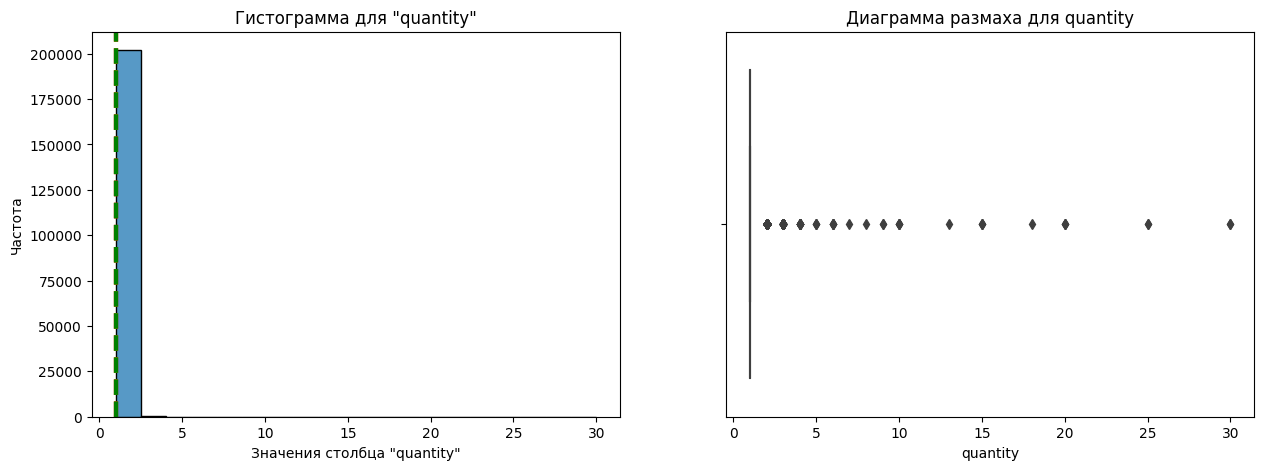

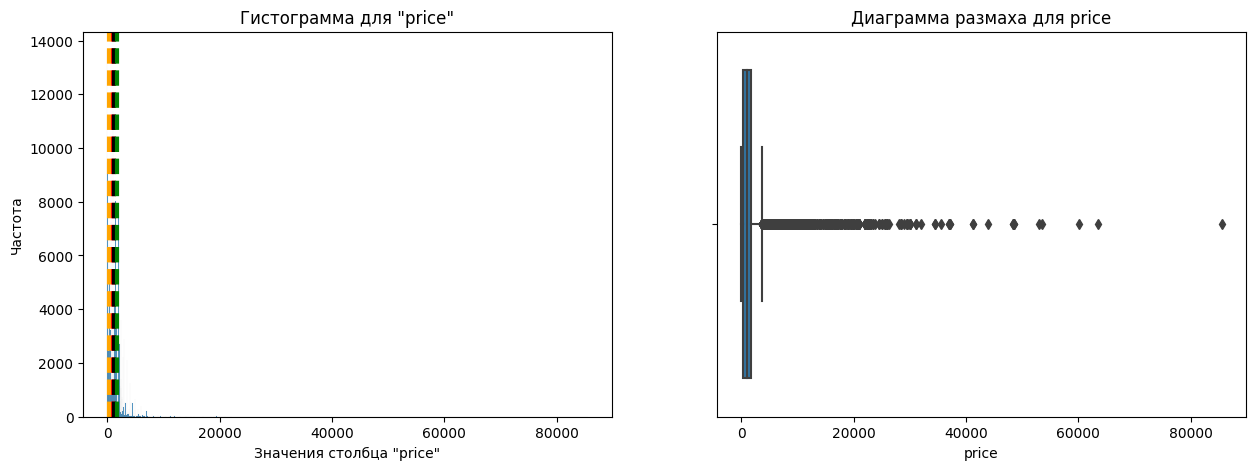

In [24]:
for i in num_col_names:
    hist_box(apparel_purchases, i)
print(apparel_purchases.describe()) 

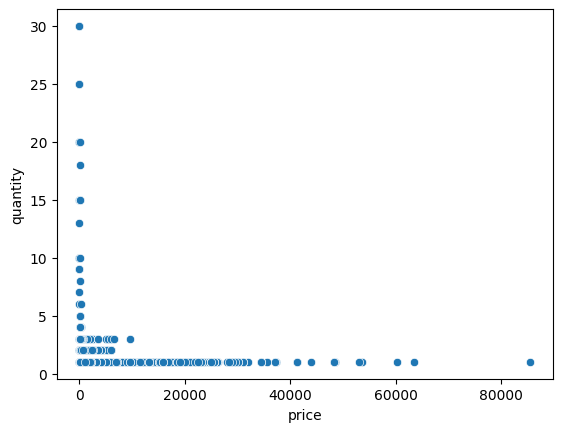

In [25]:
sns.scatterplot(data=apparel_purchases, x='price', y='quantity');
plt.show()

In [26]:
#Аномальные значения находятся после 40 тысяч. исключим значения цены более 40 тысяч.
print('Кол-во строк до удаления',apparel_purchases.shape[0])
apparel_purchases= apparel_purchases[apparel_purchases['price']<=40000]
print('Кол-во строк после удаления',apparel_purchases.shape[0])

Кол-во строк до удаления 202208
Кол-во строк после удаления 202196


## Разработка признаков:

### Разработка прихнаков для 'apparel_purchases'

Согласно заданию "В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как
обработать такие случаи – можете предлагать свои варианты решения.
Признак category_ids например ['4', '27', '176', '524'] отражает категории и подкатегории продукта.
Подкатегория 44 может быть на любом месте, в связи с чем нет возможности определить категории и что они означают.
Исходя из этого оставим только главную кагегорию.

Из apparel_purchases можем создать следующие признаки по клинету.
- Общее количество покупок в разрезе клинета.
- Количество покупок по категоряим.
- Общая выручка = количество * доход.

In [27]:
def category(x):
    if len(x) >= 1:
        return (f'cat_{x[0]}')
    else:
        return 'No_cat'

In [28]:
#сформируем признак категорий
apparel_purchases['category'] = apparel_purchases['category_ids'].apply(category)

In [29]:
# Создаем признак с годом
apparel_purchases['year'] = apparel_purchases['date'].dt.year

**category_purchases**

In [30]:
#признак количество покупок в ктегории
category_purchases = apparel_purchases.pivot_table(values = 'price',index='client_id', columns ='category', aggfunc= 'sum').fillna(0)
display(category_purchases.head(2))
print('Размерность category_purchases:', category_purchases.shape)

category,No_cat,cat_1,cat_2,cat_3,cat_4,cat_5,cat_5562,cat_5963,cat_6060,cat_None
client_id,,,,,,,,,,
1515915625468060902,0.00,0.00,0.00,0.00,6993.00,0.00,0.00,0.00,0.00,0.00
1515915625468061003,0.00,0.00,0.00,0.00,16235.00,0.00,0.00,0.00,0.00,0.00


Размерность category_purchases: (49845, 10)


**aggregated_revenue**

In [31]:
# Находим выручку и количество купленных товаров на каждого пользователя от каждой покупки
apparel_purchases['revenue'] = apparel_purchases['quantity'] * apparel_purchases['price']

In [32]:
# Находим агрегированная выручка по клиентам
aggregated_revenue = apparel_purchases.groupby('client_id')[['revenue', 'quantity']].agg('sum').reset_index()

In [33]:
aggregated_revenue = apparel_purchases.pivot_table(values=['revenue', 'quantity'], index='client_id', aggfunc= ['sum'])
aggregated_revenue.columns = ['quantity','revenue']

In [34]:
aggregated_revenue.head(2)

,quantity,revenue
client_id,,
1515915625468060902,7,6993.00
1515915625468061003,7,16235.00


In [35]:
#Выручка и количество купленных товаров по годам в разрезе пользователей
aggregated_revenue_year = apparel_purchases.pivot_table(values=['revenue', 'quantity'], index='client_id', columns ='year', aggfunc= 'sum').fillna(0)
#aggregated_revenue_year.columns = ['revenue_2022', 'revenue_2023', 'revenue_2024']
aggregated_revenue_year.columns = ['quantity_2022','quantity_2023','quantity_2024','revenue_2022', 'revenue_2023', 'revenue_2024']
display(aggregated_revenue_year.head(1))

,quantity_2022,quantity_2023,quantity_2024,revenue_2022,revenue_2023,revenue_2024
client_id,,,,,,
1515915625468060902,7.00,0.00,0.00,6993.00,0.00,0.00


In [36]:
#объеденим признаки
aggregated_revenue =aggregated_revenue.merge(aggregated_revenue_year, on='client_id')
display(aggregated_revenue.head(2))

,quantity,revenue,quantity_2022,quantity_2023,quantity_2024,revenue_2022,revenue_2023,revenue_2024
client_id,,,,,,,,
1515915625468060902,7,6993.00,7.00,0.00,0.00,6993.00,0.00,0.00
1515915625468061003,7,16235.00,0.00,7.00,0.00,0.00,16235.00,0.00


In [37]:
#***
# Добавим квадраты признаков
aggregated_revenue[['quantity_sq','revenue_sq','quantity_2022_sq','quantity_2023_sq','quantity_2024_sq','revenue_2022_sq', 'revenue_2023_sq','revenue_2024_sq']]=\
aggregated_revenue[['quantity','revenue','quantity_2022','quantity_2023','quantity_2024','revenue_2022', 'revenue_2023', 'revenue_2024']]**2

In [38]:
display(aggregated_revenue.head(2))

,quantity,revenue,quantity_2022,quantity_2023,quantity_2024,revenue_2022,revenue_2023,revenue_2024,quantity_sq,revenue_sq,quantity_2022_sq,quantity_2023_sq,quantity_2024_sq,revenue_2022_sq,revenue_2023_sq,revenue_2024_sq
client_id,,,,,,,,,,,,,,,,
1515915625468060902,7,6993.00,7.00,0.00,0.00,6993.00,0.00,0.00,49,48902049.00,49.00,0.00,0.00,48902049.00,0.00,0.00
1515915625468061003,7,16235.00,0.00,7.00,0.00,0.00,16235.00,0.00,49,263575225.00,0.00,49.00,0.00,0.00,263575225.00,0.00


In [39]:
print('Размерность aggregated_revenue:', aggregated_revenue.shape)

Размерность aggregated_revenue: (49845, 16)


**Вывод** На основани 'apparel_purchases' свормирован ряд признаков в группах :
- Размерность aggregated_revenue: (49845, 16)
- Размерность category_purchases: (49845, 10)

### Разработка признаков для 'apparel_messges'

In [40]:
apparel_messages['year'] = apparel_messages['date'].dt.year.astype('str')
apparel_messages['month'] = apparel_messages['date'].dt.month.astype('str')
apparel_messages['event']
apparel_messages.head(2)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,year,month
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,2022,5
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,2022,5


**actions_count**

In [41]:
#Подсчет количства действий
actions_count = apparel_messages.pivot_table(values='channel',index = 'client_id', columns = 'event', aggfunc ='count').fillna(0).reset_index()
actions_count.columns = ['client_id','click','close','complain','hard_bounce','hbq_spam','open','purchase','send','soft_bounce','subscribe','unsubscribe']

In [42]:
actions_count.head(2)

,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10.00,0.00,0.00,0.00,0.00,35.00,5.00,126.00,0.00,0.00,1.00
1,1515915625468061003,5.00,0.00,0.00,0.00,0.00,5.00,1.00,154.00,0.00,0.00,0.00


In [43]:
print('Размерность actions_count:', actions_count.shape)

Размерность actions_count: (53329, 12)


**channels_count**

In [44]:
# Подсчет всех видов каналов 
channels_count = apparel_messages.pivot_table(values= 'event',index = 'client_id', columns = 'channel', aggfunc ='count').fillna(0).reset_index()
channels_count.rename = ['client_id','email','mobile_push']                       

In [45]:
display(channels_count.head(3))

channel,client_id,email,mobile_push
0,1515915625468060902,177.00,0.00
1,1515915625468061003,165.00,0.00
2,1515915625468061099,182.00,94.00


In [46]:
print('Размерность channels_count:', channels_count.shape)

Размерность channels_count: (53329, 3)


**actions_count_year**

In [47]:
# Датафрейм с количеством действий по видам за 2022 - 2024 года
actions_count_year = apparel_messages.pivot_table(index='client_id', columns=['year', 'event'], 
                             values='bulk_campaign_id', aggfunc='count').fillna(0)
actions_count_year.columns = ['_'.join(col) for col in actions_count_year.columns]

In [48]:
# Количество "хороших" действий по годам
actions_count_year['good_actions_2022'] = actions_count_year[['2022_click', '2022_open', '2022_purchase', '2022_subscribe']].sum(axis=1)
actions_count_year['good_actions_2023'] = actions_count_year[['2023_click', '2023_open', '2023_purchase', '2023_subscribe']].sum(axis=1)
actions_count_year['good_actions_2024'] = actions_count_year[['2024_click', '2024_open', '2024_purchase', '2024_subscribe']].sum(axis=1)

In [49]:
# Количество плохих действий по годам
actions_count_year['bad_actions_2022'] = actions_count_year[['2022_complain', '2022_hbq_spam', '2022_unsubscribe']].sum(axis=1)
actions_count_year['bad_actions_2023'] = actions_count_year[['2023_click', '2023_open', '2023_purchase', '2023_subscribe']].sum(axis=1)
actions_count_year['bad_actions_2024'] = actions_count_year[['2024_click', '2024_open', '2024_purchase', '2024_subscribe']].sum(axis=1)

In [50]:
display(actions_count_year.head(2))

,2022_click,2022_complain,2022_hard_bounce,2022_hbq_spam,2022_open,2022_purchase,2022_send,2022_soft_bounce,2022_subscribe,2022_unsubscribe,2023_click,2023_close,2023_complain,2023_hard_bounce,2023_hbq_spam,2023_open,2023_purchase,2023_send,2023_soft_bounce,2023_subscribe,2023_unsubscribe,2024_click,2024_hard_bounce,2024_hbq_spam,2024_open,2024_purchase,2024_send,2024_soft_bounce,2024_subscribe,2024_unsubscribe,good_actions_2022,good_actions_2023,good_actions_2024,bad_actions_2022,bad_actions_2023,bad_actions_2024
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,8.00,0.00,0.00,0.00,17.00,5.00,49.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,0.00,71.00,0.00,0.00,0.00,2.00,0.00,0.00,4.00,0.00,6.00,0.00,0.00,1.00,30.00,14.00,6.00,0.00,14.00,6.00
1515915625468061003,0.00,0.00,0.00,0.00,1.00,0.00,57.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,4.00,1.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,0.00,0.00,0.00,1.00,10.00,0.00,0.00,10.00,0.00


In [51]:
print('Размерность actions_count_year:', actions_count_year.shape)

Размерность actions_count_year: (53329, 36)


**Вывод** На основани 'apparel_messges' свормирован ряд признаков в группах :
- Размерность actions_count: (53329, 12)
- Размерность actions_count_year: (53329, 36)
- Размерность channels_count: (53329, 3)

### Агрегация данных из `full_campaign_daily_event` и `full_campaign_daily_event_channel`

**campaigns_data**


Из датасетов full_campaign_daily_event и full_campaign_daily_event_channel агрегируем информацию по идетификатору рассылок. 

In [52]:
#агрегация для full_campaign_daily_event
campaigns_aggregate = full_campaign_daily_event.groupby('bulk_campaign_id')[full_campaign_daily_event.columns[2:]].sum().reset_index()
campaigns_aggregate.head(2)

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,548,0,0,0,5,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0
1,563,37,6,0,49,1,0,0,0,0,37,6,0,48,1,0,0,0,0,0,0,0,0


In [53]:
#агрегация для full_campaign_daily_event_channel
campaigns_channels_aggregate = full_campaign_daily_event_channel.groupby('bulk_campaign_id')[full_campaign_daily_event_channel.columns[2:]].sum().reset_index()
campaigns_channels_aggregate.head(2)

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,548,0,0,5,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,563,37,0,49,0,1,0,0,0,0,37,0,48,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0


На основании вышеперечисленных данных можно выделить хорошие рассылочные кампании и плохие по тем или иным критериям. Основные критерии "хорошей" рассылки - покупка в результате рассылки, количество кликов, подписок и т.п. Основные критерии "плохой" рассылки  - отписка, жалоба спам.

Можно в будущем добавить сумму/среднее количество перечисленных показателей в готовый датасет.

In [54]:
campaigns_data = apparel_messages.merge(campaigns_aggregate, on='bulk_campaign_id')\
                        .groupby('client_id')[campaigns_aggregate.columns[1:]]\
                        .agg('mean').reset_index()

campaigns_data.columns = ['client_id'] + ['campaign_' + c for c in campaigns_data.columns[1:]]

campaigns_data.head(2)

,client_id,campaign_count_click,campaign_count_complain,campaign_count_hard_bounce,campaign_count_open,campaign_count_purchase,campaign_count_send,campaign_count_soft_bounce,campaign_count_subscribe,campaign_count_unsubscribe,campaign_nunique_click,campaign_nunique_complain,campaign_nunique_hard_bounce,campaign_nunique_open,campaign_nunique_purchase,campaign_nunique_send,campaign_nunique_soft_bounce,campaign_nunique_subscribe,campaign_nunique_unsubscribe,campaign_count_hbq_spam,campaign_nunique_hbq_spam,campaign_count_close,campaign_nunique_close
0,1515915625468060902,21643.77,396.07,3802.60,205640.81,203.05,2103680.02,12243.12,72.66,3076.68,16457.75,391.41,3765.71,199347.25,160.36,2102091.49,12179.58,69.43,2880.81,182.07,181.64,0.00,0.00
1,1515915625468061003,22044.70,349.53,4830.07,196638.82,202.26,2107041.18,11595.81,77.69,3259.98,16601.42,345.49,4806.74,191016.39,161.84,2105012.14,11451.71,74.10,3051.24,436.62,436.43,0.00,0.00


In [55]:
print('Размерность campaigns_data:', campaigns_data.shape)

Размерность campaigns_data: (53329, 23)


На основании `full_campaign_daily_event` и `full_campaign_daily_event_channel` сделаны признаки:
Размерность campaigns_data: (53329, 23)


### Создание данных для обучения  модели

In [56]:
#category_purchases
#aggregated_revenue
#channels_count
#actions_count
#actions_count_year
#campaigns_data

In [57]:
#В таблице apparel_target_binary все строики уникальные, это проверили на этапе загрузки данных.
#Добавим разработанные признаки.
data = apparel_target_binary.merge(category_purchases, on ='client_id', how='left')\
                            .merge(aggregated_revenue, on ='client_id', how='left')\
                            .merge(channels_count, on ='client_id', how='left')\
                            .merge(actions_count, on ='client_id', how='left')\
                            .merge(actions_count_year, on ='client_id', how='left')\
                            .merge(campaigns_data, on ='client_id', how='left')

data=data.set_index('client_id')
print('Размерность data:', data.shape)
display(data.head(2))

Размерность data: (49849, 98)


,target,No_cat,cat_1,cat_2,cat_3,cat_4,cat_5,cat_5562,cat_5963,cat_6060,cat_None,quantity,revenue,quantity_2022,quantity_2023,quantity_2024,revenue_2022,revenue_2023,revenue_2024,quantity_sq,revenue_sq,quantity_2022_sq,quantity_2023_sq,quantity_2024_sq,revenue_2022_sq,revenue_2023_sq,revenue_2024_sq,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,2022_click,2022_complain,2022_hard_bounce,2022_hbq_spam,2022_open,2022_purchase,2022_send,2022_soft_bounce,2022_subscribe,2022_unsubscribe,2023_click,2023_close,2023_complain,2023_hard_bounce,2023_hbq_spam,2023_open,2023_purchase,2023_send,2023_soft_bounce,2023_subscribe,2023_unsubscribe,2024_click,2024_hard_bounce,2024_hbq_spam,2024_open,2024_purchase,2024_send,2024_soft_bounce,2024_subscribe,2024_unsubscribe,good_actions_2022,good_actions_2023,good_actions_2024,bad_actions_2022,bad_actions_2023,bad_actions_2024,campaign_count_click,campaign_count_complain,campaign_count_hard_bounce,campaign_count_open,campaign_count_purchase,campaign_count_send,campaign_count_soft_bounce,campaign_count_subscribe,campaign_count_unsubscribe,campaign_nunique_click,campaign_nunique_complain,campaign_nunique_hard_bounce,campaign_nunique_open,campaign_nunique_purchase,campaign_nunique_send,campaign_nunique_soft_bounce,campaign_nunique_subscribe,campaign_nunique_unsubscribe,campaign_count_hbq_spam,campaign_nunique_hbq_spam,campaign_count_close,campaign_nunique_close
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,0.00,0.00,0.00,0.00,6993.00,0.00,0.00,0.00,0.00,0.00,7.00,6993.00,7.00,0.00,0.00,6993.00,0.00,0.00,49.00,48902049.00,49.00,0.00,0.00,48902049.00,0.00,0.00,177.00,0.00,10.00,0.00,0.00,0.00,0.00,35.00,5.00,126.00,0.00,0.00,1.00,8.00,0.00,0.00,0.00,17.00,5.00,49.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,0.00,71.00,0.00,0.00,0.00,2.00,0.00,0.00,4.00,0.00,6.00,0.00,0.00,1.00,30.00,14.00,6.00,0.00,14.00,6.00,21643.77,396.07,3802.60,205640.81,203.05,2103680.02,12243.12,72.66,3076.68,16457.75,391.41,3765.71,199347.25,160.36,2102091.49,12179.58,69.43,2880.81,182.07,181.64,0.00,0.00
1515915625468061003,1,0.00,0.00,0.00,0.00,16235.00,0.00,0.00,0.00,0.00,0.00,7.00,16235.00,0.00,7.00,0.00,0.00,16235.00,0.00,49.00,263575225.00,0.00,49.00,0.00,0.00,263575225.00,0.00,165.00,0.00,5.00,0.00,0.00,0.00,0.00,5.00,1.00,154.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,57.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,4.00,1.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,0.00,0.00,0.00,1.00,10.00,0.00,0.00,10.00,0.00,22044.70,349.53,4830.07,196638.82,202.26,2107041.18,11595.81,77.69,3259.98,16601.42,345.49,4806.74,191016.39,161.84,2105012.14,11451.71,74.10,3051.24,436.62,436.43,0.00,0.00


### КОРРЕЛЯЦИОННЫЙ Анализ

In [58]:
num_col_names = data.select_dtypes(include='number').columns.tolist()

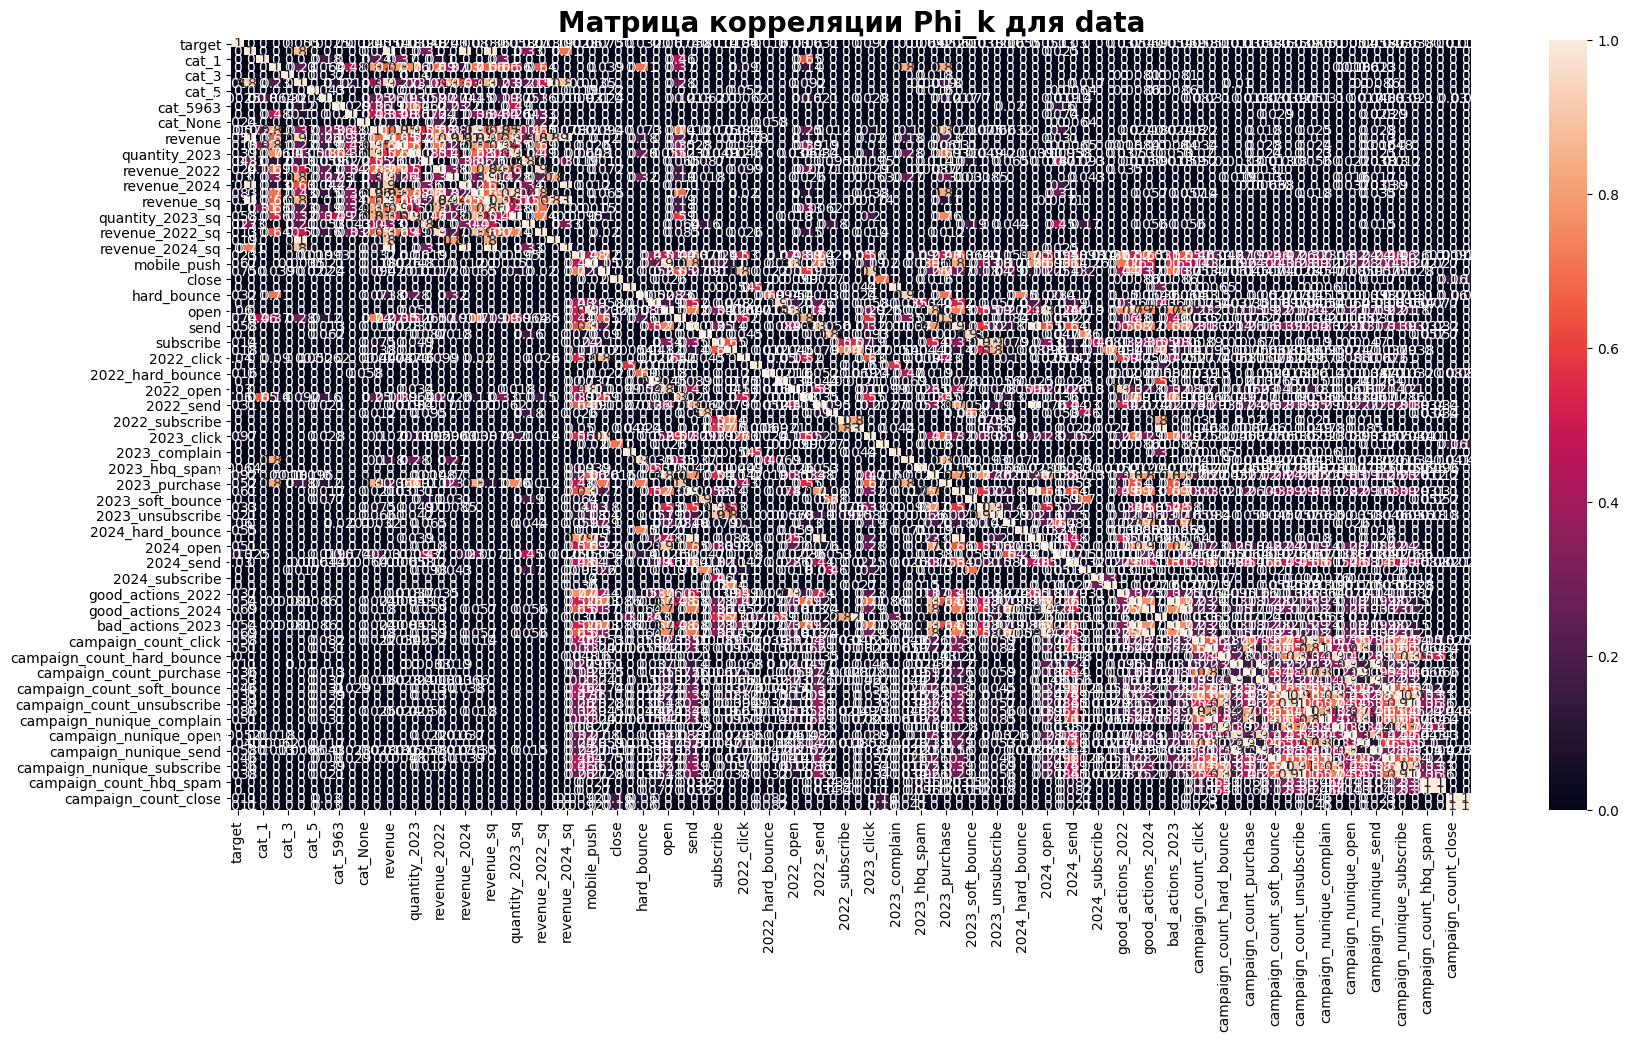

In [59]:
#вычисление матрицы корреляции
corr_matrix = data.phik_matrix(interval_cols=num_col_names)


#визуализация матрицы корреляции 
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Матрица корреляции Phi_k для data', fontsize=20, fontweight="bold" )
plt.show()

In [60]:
display(corr_matrix)

,target,No_cat,cat_1,cat_2,cat_3,cat_4,cat_5,cat_5562,cat_5963,cat_6060,cat_None,quantity,revenue,quantity_2022,quantity_2023,quantity_2024,revenue_2022,revenue_2023,revenue_2024,quantity_sq,revenue_sq,quantity_2022_sq,quantity_2023_sq,quantity_2024_sq,revenue_2022_sq,revenue_2023_sq,revenue_2024_sq,email,mobile_push,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,2022_click,2022_complain,2022_hard_bounce,2022_hbq_spam,2022_open,2022_purchase,2022_send,2022_soft_bounce,2022_subscribe,2022_unsubscribe,2023_click,2023_close,2023_complain,2023_hard_bounce,2023_hbq_spam,2023_open,2023_purchase,2023_send,2023_soft_bounce,2023_subscribe,2023_unsubscribe,2024_click,2024_hard_bounce,2024_hbq_spam,2024_open,2024_purchase,2024_send,2024_soft_bounce,2024_subscribe,2024_unsubscribe,good_actions_2022,good_actions_2023,good_actions_2024,bad_actions_2022,bad_actions_2023,bad_actions_2024,campaign_count_click,campaign_count_complain,campaign_count_hard_bounce,campaign_count_open,campaign_count_purchase,campaign_count_send,campaign_count_soft_bounce,campaign_count_subscribe,campaign_count_unsubscribe,campaign_nunique_click,campaign_nunique_complain,campaign_nunique_hard_bounce,campaign_nunique_open,campaign_nunique_purchase,campaign_nunique_send,campaign_nunique_soft_bounce,campaign_nunique_subscribe,campaign_nunique_unsubscribe,campaign_count_hbq_spam,campaign_nunique_hbq_spam,campaign_count_close,campaign_nunique_close
target,1.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.02,0.05,0.05,0.02,0.04,0.05,0.02,0.03,0.00,0.08,0.04,0.00,0.06,0.03,0.01,0.02,0.00,0.02,0.07,0.07,0.00,0.00,0.03,0.00,0.06,0.07,0.06,0.00,0.01,0.02,0.04,0.00,0.02,0.00,0.03,0.06,0.03,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.01,0.09,0.05,0.06,0.00,0.03,0.02,0.06,0.06,0.00,0.05,0.13,0.03,0.00,0.00,0.00,0.04,0.05,0.07,0.00,0.05,0.07,0.06,0.05,0.00,0.01,0.04,0.05,0.05,0.04,0.04,0.09,0.05,0.00,0.01,0.04,0.06,0.05,0.04,0.04,0.00,0.00,0.01,0.01
No_cat,0.00,1.00,0.00,0.00,0.00,0.89,0.00,0.00,0.00,0.00,0.00,0.07,1.00,0.00,0.00,0.31,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.33,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cat_1,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.24,0.00,0.37,0.00,0.00,0.11,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cat_2,0.00,0.00,0.00,1.00,0.00,0.23,0.00,0.06,0.00,0.48,0.00,0.82,0.67,0.81,0.76,0.12,0.69,0.37,0.13,0.71,0.66,0.66,0.56,0.00,0.64,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.71,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.83,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cat_3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cat_4,0.06,0.89,0.00,0.23,0.00,1.00,0.00,0.

## Обучение модели

### Разделение на тренировочную и тестовую выборки

In [61]:
#разделение на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1),
                                                    data['target'],
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37386, 97), (37386,), (12463, 97), (12463,))

In [62]:
# Выбираем количественные и категориальные признаки
num_columns = X_train.select_dtypes(include='number').columns
cat_columns = X_train.select_dtypes(exclude='number').columns

In [63]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([ 
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent',fill_value='unknown')), 
    ('ohe', OneHotEncoder(drop = 'first', categories = 'auto',
                          handle_unknown = 'ignore',sparse = False))
    ])


In [64]:
# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

In [65]:
# Pipe for numerical data
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                     ('scaler', StandardScaler())
                    ])

In [66]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [67]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(class_weight='balanced',  random_state=RANDOM_STATE))
])

In [68]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_va...
       'campaign_nunique_open', 'campaign_nunique_purchase',
       'campaign_nunique_send', 'campaign_nunique_soft_bounce',
       'campaign_nunique_subscribe', 'campaign_nunique_unsubscribe',
       'campaign_count_hbq_spam', 'campaign_nunique_hbq_spam',
       'campaign_count_close', 'campaign_nunique_close'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [69]:
# Функция для расчета основных метрик
def metrics(model, data_X_train, data_y_train, data_X_test, data_y_test, prob=True):
    # Расчитаем основную метрику для кросс-валидации
    roc_auc_train = cross_val_score(model, data_X_train, data_y_train, scoring='roc_auc', cv=3).mean()
    
    # Сделаем предсказание
    y_pred = model.predict(data_X_test)
    
    if prob:
        probs = model.predict_proba(data_X_test)[:, 1]
    
    # Расчитаем другие метрики на тесте
    roc_auc_test = roc_auc_score(data_y_test, probs)
    accuracy = accuracy_score(y_pred, data_y_test)
    f1 = f1_score(y_pred, data_y_test)
    precision = precision_score(y_pred, data_y_test)
    recall = recall_score(y_pred, data_y_test)
    
    
    return pd.DataFrame([roc_auc_train, roc_auc_test, accuracy, f1, precision, recall],
                 index=['roc_auc_train', 'roc_auc_test', 'accuracy', 'f1', 'precision', 'recall'],
                 columns=['metrics']).round(2)

In [70]:
baseline = metrics(pipe_final, X_train, y_train, X_test, y_test)

In [71]:
display(baseline)

,metrics
roc_auc_train,0.74
roc_auc_test,0.75
accuracy,0.76
f1,0.10
precision,0.62
recall,0.05


Baseline модель показала неплохой результат на метрике `roc_auc`.

**LogisticRegression**

In [72]:
params_lr = [{'model': [LogisticRegression(class_weight='balanced',  random_state=RANDOM_STATE)],
              'model__C': np.arange(0.01, 0.9, 0.05),
             }]

In [73]:
random_lr = RandomizedSearchCV(
    pipe_final, 
    param_distributions=params_lr, 
    n_iter=15, 
    scoring='roc_auc', 
    cv=3, 
    random_state=RANDOM_STATE, 
    verbose=1)

In [74]:
random_lr.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index([], dtype='object')),
                                                                              ('num',
                                                                               Pipeline(steps...
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42))]),
                   n_iter=15,
                   param_distributions=[{'model': [LogisticRegression(C=0.16000000000000003,
                                                                      class_weight='balanced',
                                                                      random_state=42)],
                                         'model__C': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86])}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [75]:
lr_metrics = metrics(random_lr, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [76]:
display(lr_metrics)

,metrics
roc_auc_train,0.74
roc_auc_test,0.76
accuracy,0.76
f1,0.10
precision,0.62
recall,0.05


**DecisionTreeClassifier**

Древо решений обычно работает плохо с датасетом, где много количественных признаков.

In [77]:
param_tree = {'model': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
#              'model__max_depth': [35, 50, 70, 100],
              'model__max_depth': [10, 50, 100],
#              'model__min_samples_leaf': [50, 80, 100, 150, 200],
              'model__min_samples_leaf': [50, 100, 150, 200],
#              'model__max_leaf_nodes': [40, 50, 70],
              'model__max_leaf_nodes': [40, 60, 80],
#              'model__min_samples_split': [2, 5, 8, 10]
              'model__min_samples_split': [2, 4,6, 8, 10]
              }

In [78]:
#Поиск параметров модели
random_tree = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_tree, 
    cv=5,
    n_iter=10,
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE,
    verbose=1
)

In [79]:
random_tree.fit(X_train, y_train)
rtree_metrics = metrics(random_tree, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [80]:
display(rtree_metrics)

,metrics
roc_auc_train,0.69
roc_auc_test,0.70
accuracy,0.71
f1,0.08
precision,0.60
recall,0.04


**LightGBM Classifier**

LightGBM Classifier скорость быстрее чем CatBoost попробуем ее.

In [81]:
params_lgbm = {'model': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
              'model__n_estimators': [150, 200, 250],
              'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
              }

In [82]:
# словарь для модели LGBMRegressor()
param_lgbm = [
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        #  'model__n_estimators':[100],
       # 'models__max_depth': range(2, 5),
       # 'models__min_samples_leaf': range(4, 6),
        'preprocessor__num': ['passthrough']  
    }]

In [83]:
random_lgbm = RandomizedSearchCV(
    pipe_final, 
    param_distributions=params_lgbm, 
    cv=5,
    n_iter=5,
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE,
    verbose=1
)

In [84]:
random_lgbm.fit(X_train, y_train)
#lgbm = rs.best_estimator_
lgbm_metrics = metrics(random_tree, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 554, number of negative: 29354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12484
[LightGBM] [Info] Number of data points in the train set: 29908, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 555, number of negative: 29354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12492
[LightGBM] [Info] Number of data points in the train set: 29909, number of used features: 88
[LightGBM] [Info] [binary:

In [85]:
display(lgbm_metrics)

,metrics
roc_auc_train,0.69
roc_auc_test,0.70
accuracy,0.71
f1,0.08
precision,0.60
recall,0.04


**RandomForestClassifier**

In [86]:
# RandomForest
params_rf = {'model': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
             'model__n_estimators': [150, 200, 250],
             'model__max_depth': [10, 50, 100], 
             'model__min_samples_leaf': [50, 100, 150,200],
             'model__max_leaf_nodes': [40, 60, 80]
            }

In [87]:
random_rf = RandomizedSearchCV(
    pipe_final, 
    param_distributions=params_rf, 
    cv=5,
    n_iter=5,
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE,
    verbose=1
)

In [88]:
random_rf.fit(X_train, y_train)
#rf = random_rf.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index([], dtype='object')),
                                                                              ('num',
                                                                               Pipeline(steps...
                   param_distributions={'model': [RandomForestClassifier(class_weight='balanced',
                                                                         max_depth=100,
                                                                         max_leaf_nodes=40,
                                                                         min_samples_leaf=100,
                                                                         n_estimators=250,
                                                                         random_state=42)],
                                        'model__max_depth': [10, 50, 100],
                                        'model__max_leaf_nodes': [40, 60, 80],
                                        'model__min_samples_leaf': [50, 100,
                                                                    150, 200],
                                        'model__n_estimators': [150, 200, 250]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [89]:
rf_metrics = metrics(random_rf, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [90]:
display(rf_metrics)

,metrics
roc_auc_train,0.76
roc_auc_test,0.76
accuracy,0.80
f1,0.10
precision,0.53
recall,0.06


**CatBoostClassifier**

In [92]:
# словарь для модели CatBoostClassifier()
params_catboost = [
    {
        'model': [CatBoostClassifier(random_state = RANDOM_STATE,
                                     verbose = False)],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': range(2, 5),
        'preprocessor__num': ['passthrough']  
    }]

In [93]:
random_catboost = RandomizedSearchCV(
    pipe_final, 
    param_distributions=params_catboost, 
    cv=5,
    scoring = 'roc_auc', 
    n_jobs=-1,
    error_score='raise',
    verbose=1
)

In [94]:
random_catboost.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index([], dtype='object')),
                                                                              (...
       'campaign_count_close', 'campaign_nunique_close'],
      dtype='object'))])),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'model': [<catboost.core.CatBoostClassifier object at 0x00000256C0303D90>],
                                         'model__learning_rate': [0.01, 0.05,
                                                                  0.1, 0.2],
                                         'model__max_depth': range(2, 5),
                                         'preprocessor__num': ['passthrough']}],
                   scoring='roc_auc', verbose=1)

In [95]:
catboost_metrics = metrics(random_catboost, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [96]:
display(catboost_metrics)

,metrics
roc_auc_train,0.76
roc_auc_test,0.77
accuracy,0.98
f1,0.01
precision,0.00
recall,1.00


## Рассмотрение метрик по моделям

In [103]:
#посомтрим все модели
all_metrics = pd.concat([lr_metrics, rtree_metrics, rf_metrics,catboost_metrics, lgbm_metrics], axis=1)
all_metrics.columns = ['logreg', 'tree', 'random_forest','catboost', 'lgbm']

In [104]:
display(all_metrics)

,logreg,tree,random_forest,catboost,lgbm
roc_auc_train,0.74,0.69,0.76,0.76,0.69
roc_auc_test,0.76,0.70,0.76,0.77,0.70
accuracy,0.76,0.71,0.80,0.98,0.71
f1,0.10,0.08,0.10,0.01,0.08
precision,0.62,0.60,0.53,0.00,0.60
recall,0.05,0.04,0.06,1.00,0.04


Вывод: Модели DecisionTreeClassifier и LightGBM Classifier не соответсвуют условию roc_auc_score>0.7

Под требование тех задания подходят 3 модели: CatBoostClassifier, RandomForestClassifier, LogisticRegression.
Следует осатновиться на модели RandomForestClassifier т.к. модель имеет наибольший roc_auc_score, а также более высокие метрики чем у других.



In [ ]:
#заготовка под SHAP
model = random_rf.best_estimator_

In [ ]:
#Обучим и преобразуем массив X_train:
#model['preprocessor'].fit(X_train)

#X_train_preprocessed = model['preprocessor'].transform(X_train)

In [ ]:
#Выделим имена столбцов массива X_train, полученные после преобразования кодировщиком и скейлером:
column_names = model['preprocessor'].get_feature_names_out()
data = pd.DataFrame(X_train_preprocessed, columns=column_names)
explainer = shap.TreeExplainer(model['models'], data=data)
shap_values = explainer(data, check_additivity=False )

#shap.summary_plot(shap_values[:,:,1], data,  plot_type='bar', plot_size = (10,5))

## Анализ важности признаков

In [105]:
model = random_rf.best_estimator_

In [106]:
#Обучим и преобразуем массив X_train:
model['preprocessor'].fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index([], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('sc...
       'campaign_count_unsubscribe', 'campaign_nunique_click',
       'campaign_nunique_complain', 'campaign_nunique_hard_bounce',
       'campaign_nunique_open', 'campaign_nunique_purchase',
       'campaign_nunique_send', 'campaign_nunique_soft_bounce',
       'campaign_nunique_subscribe', 'campaign_nunique_unsubscribe',
       'campaign_count_hbq_spam', 'campaign_nunique_hbq_spam',
       'campaign_count_close', 'campaign_nunique_close'],
      dtype='object'))])

In [107]:
X_train_preprocessed = model['preprocessor'].transform(X_train)

100%|===================| 74728/74772 [16:58<00:00]        

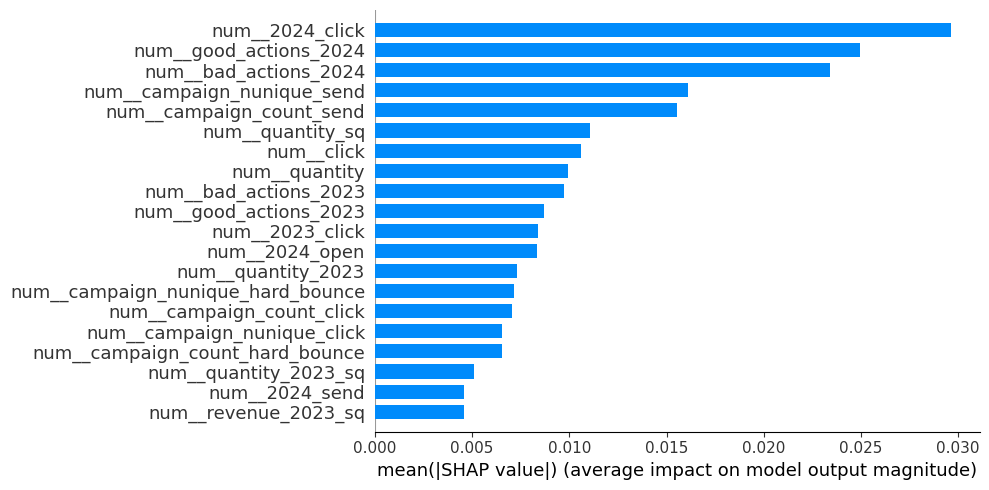

In [109]:
#Выделим имена столбцов массива X_train, полученные после преобразования кодировщиком и скейлером:
column_names = model['preprocessor'].get_feature_names_out()
data = pd.DataFrame(X_train_preprocessed, columns=column_names)
explainer = shap.TreeExplainer(model['model'], data=data)
shap_values = explainer(data, check_additivity=False )

shap.summary_plot(shap_values[:,:,1], data,  plot_type='bar', plot_size = (10,5))

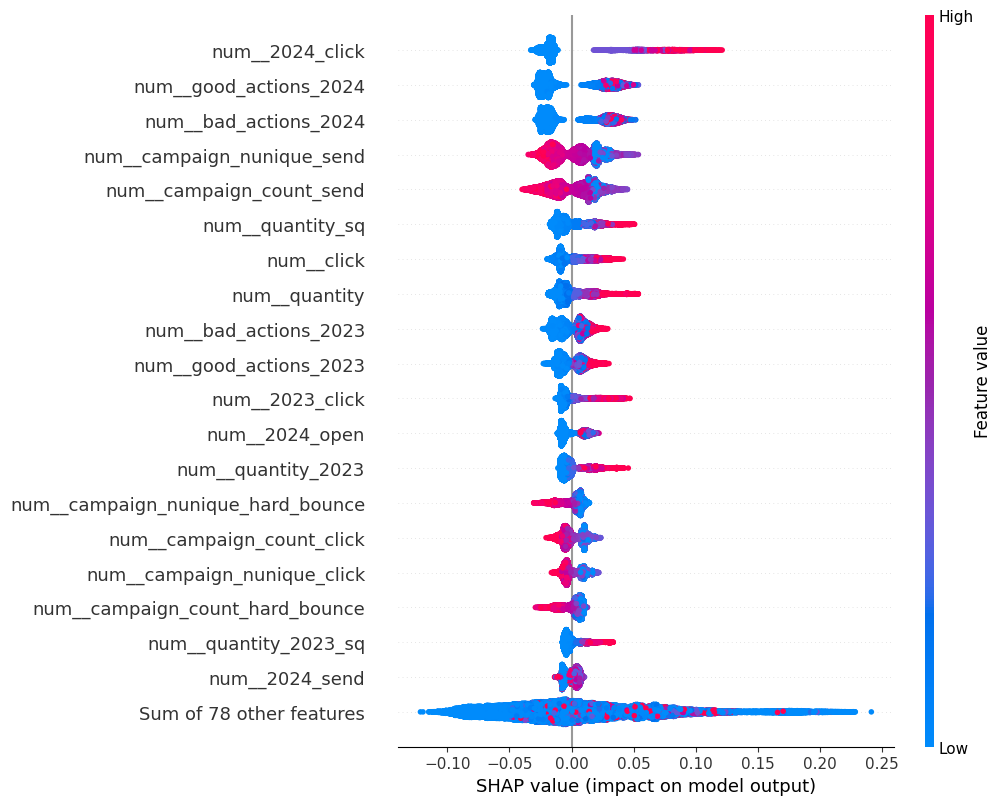

In [110]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

In [111]:
display(all_metrics)

,logreg,tree,random_forest,catboost,lgbm
roc_auc_train,0.74,0.69,0.76,0.76,0.69
roc_auc_test,0.76,0.70,0.76,0.77,0.70
accuracy,0.76,0.71,0.80,0.98,0.71
f1,0.10,0.08,0.10,0.01,0.08
precision,0.62,0.60,0.53,0.00,0.60
recall,0.05,0.04,0.06,1.00,0.04


**Вывод:** Модели DecisionTreeClassifier и LightGBM Classifier не соответсвуют условию roc_auc_score>0.7

Под требование тех задания подходят 3 модели: CatBoostClassifier, RandomForestClassifier, LogisticRegression.
Следует осатновиться на модели RandomForestClassifier т.к. модель имеет наибольший roc_auc_score, а также более высокие метрики чем у других.
